# Windy-cliff-walking with direct optimization

####  The network is updated by direct optimization which searches across all of the combinations of 4 steps (4^4). The gumbels are sampled in top-down construction with conditional probabilities 


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from matplotlib.colors import hsv_to_rgb


## ######################## environment ########################## #

In [2]:
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [3]:
steps = 4
height = 2*steps+1
width = 2*steps+1
start = (steps,steps)
obj = (steps,2*steps-2)



In [4]:
class GridWorld:
    terrain_color = dict(normal=[127.0/360, 0.0, 96.0/100],
                         objective=[26.0/360, 100.0/100, 100.0/100],
                         cliff=[247.0/360, 92.0/100, 70.0/100],
                         player=[344.0/360, 93.0/100, 100.0/100])        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((height, width, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid,history = None):
        grid[start[0], start[1]:obj[1]] = self.terrain_color['cliff']
        grid[obj] = self.terrain_color['objective']
        grid[start] = self.terrain_color['player']
        if history is not None:
            for idx in history:
                grid[self._id_to_position(idx)] = self.terrain_color['player']
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.ax.grid(which='minor')
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], s='0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(height * width)]  
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(width))
        self.ax.set_xticks(np.arange(width) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(height))
        self.ax.set_yticks(np.arange(height) - 0.5, minor=True)
        
    def reset(self):
        self.player = start      
        return self._position_to_id(self.player)
    
    def step(self, action):
        # Possible actions        
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < height - 1:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < width - 1:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        self._add_wind(self.player[1])            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
            
        return self._position_to_id(self.player), reward, done
    
    def _add_wind(self,x_loc):
        
        #wind_row = [0.4,0]
        #y_loc = 0 if self.player[0]%2 ==0 and self.player[1]%2 ==0 else 1
        p = np.random.random()
        if p<wind[x_loc] and self.player[0] < height-1:
            self.player = (self.player[0]+1, self.player[1])
            
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * width + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // width), (idx % width)
        
    def render(self, q_values=None, action=None,history = None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((height, width, 3))
            values = change_range(np.max(q_values, -1)).reshape(height, width)
            grid[:, :, 1] = values
            self._add_objectives(grid,history)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(width), height)
            ys = np.tile(np.arange(height), width)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)


In [5]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
ACTIONS = ['UP', 'DOWN', 'RIGHT', 'LEFT']

wind = [0 for _ in range(width)] # probability of being pushed down at column i
wind[5] = 0.1


In [6]:
wind

[0, 0, 0, 0, 0, 0.1, 0, 0, 0]

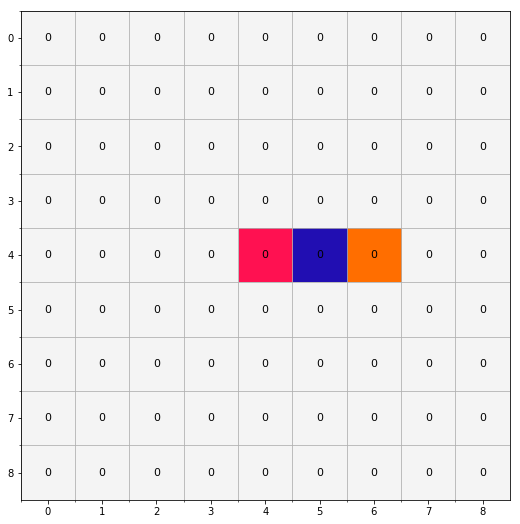

In [7]:
env = GridWorld()

#### definition of trajectory space

In [8]:

num_states = width * height
num_actions = 4
traj_space = list(itertools.product(range(num_actions),repeat = steps)) #len of num_actions ** steps
traj_to_idx = {t : i for i,t in enumerate(traj_space)}

desired_shape = [num_actions for i in range(steps)]
desired_shape.append(steps)

traj_tensor = np.array(traj_space).reshape(desired_shape)
#traj_tensor


In [9]:
def run_episode(actions_list):
    rewards = []
    done = False
    success = False
    R = 0
    state = env.reset()
    for action in actions_list:
        
        if not done:
            state, reward, done = env.step(action)
        if reward==0:
            success = True
        #print env._id_to_position(state)
        rewards.append(reward)
        
    for r in rewards[::-1]:
        R = r + 0.99 * R   # gamma = 0.9
        rewards.insert(0, R)
    return sum(rewards),success

## Policy Gradient with Gumbels

Note that the policy network doesn't get any variable as input

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import collections


In [11]:
def sample_gumbel(mu):
    """Sample a Gumbel(mu)."""    
    return -np.log(np.random.exponential()) + mu


def sample_truncated_gumbel(mu, b):
    """Sample a Gumbel(mu) truncated to be less than b."""    
    return -np.log(np.random.exponential() + np.exp(-b + mu)) + mu

  
def sample_gumbel_argmax(logits):
    """Sample from a softmax distribution over logits.

    TODO: check this is correct.

    Args:
    logits: A flat numpy array of logits.

    Returns:
    A sample from softmax(logits).
    """
    return np.argmax(-np.log(np.random.exponential(size=logits.shape)) + logits)


def logsumexp(logits):
    c = np.max(logits)
    return np.log(np.sum(np.exp(logits - c))) + c


def log_softmax(logits, axis=1):
    """Normalize logits per row so that they are logprobs.
  
      TODO: check this is correct. 
    """
    maxes = np.max(logits, axis=axis, keepdims=True)
    offset_logits = logits - maxes
    log_zs = np.log(np.sum(np.exp(offset_logits), axis=axis, keepdims=True))
    return offset_logits - log_zs

In [12]:
# Make a node without a state, and also don't allow `next_actions` to be None.
# Just put in all possible next actions when the node is created.
Node = collections.namedtuple('Node', 
                              [
                                  'prefix',
                                  'logprob_so_far',
                                  'max_gumbel', 
                                  'next_actions',
                              ])

# Namedtuple for storing results
Trajectory = collections.namedtuple('Trajectory', ['actions', 'gumbel'])


def sample_trajectory_gumbels(conditional_logprobs, max_length):
    """Samples an independent Gumbel(logprob) for each trajectory in top-down-ish order.
    Args:
    conditional_logprobs: A max_length list where each element contains logprobs conditioned on the previous
    time steps. for example, if num_actions = 2 and max_length = 3 so 
    conditional_logprobs = log of
        [0.39745218 0.6025478 ] # p(t_1)
        
        [[0.82647455 0.1735254 ]  # p(t_2|t_1)
         [0.12566252 0.87433743]]
        
        [[[0.533708   0.46629202]  # p(t_3|t_2,t_1)
          [0.5119377  0.48806235]]

         [[0.8158274  0.18417251]
          [0.97107804 0.02892203]]].
    max_length: Maximum length of a trajectory to allow.
    """    
    num_actions = conditional_logprobs[0].shape[0]
    # Start with a node for all trajectories.
    root_node = Node(prefix=[], 
                   logprob_so_far=0,
                   max_gumbel=sample_gumbel(0), 
                   next_actions=range(num_actions))
    queue = [root_node]
    final_trajectories = []
    while queue:        
        parent = queue.pop()        
        if len(parent.prefix) == max_length:
            t = Trajectory(actions=parent.prefix, gumbel=parent.max_gumbel) 
            final_trajectories.append(t)
            continue

        # Choose one action from amongst the set of candidates to inherit the max
        # gumbel. Call this the "special" action.
        action_logprobs = conditional_logprobs[len(parent.prefix)]
        for prev in parent.prefix:
            action_logprobs = action_logprobs[prev]
        #action_logprobs = get_actions_logprobs(parent.prefix)
        next_action_logprobs = action_logprobs[parent.next_actions]
        special_action_index = sample_gumbel_argmax(next_action_logprobs)
        special_action = parent.next_actions[special_action_index]
        special_action_logprob = action_logprobs[special_action]

        special_child = Node(prefix=parent.prefix + [special_action],
                             logprob_so_far=parent.logprob_so_far + special_action_logprob,
                             max_gumbel=parent.max_gumbel, 
                             next_actions=range(num_actions))  # All next actions are possible.
        queue.append(special_child)

        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.
        other_actions = [i for i in parent.next_actions if i != special_action]

        assert len(other_actions) == len(parent.next_actions) - 1

        if other_actions:
            other_max_location = logsumexp(action_logprobs[other_actions])
            other_max_gumbel = sample_truncated_gumbel(parent.logprob_so_far + other_max_location, 
                                                     parent.max_gumbel)
            other_children = Node(prefix=parent.prefix,
                                logprob_so_far=parent.logprob_so_far,
                                max_gumbel=other_max_gumbel,
                                next_actions=other_actions)            
            queue.append(other_children)

    return final_trajectories

t_i = (z1,...,z4) 4 actions probs

#### the goal is to convert softmax layer outputs to conditionals:
p(t_1,..,t_n) = p(t_1)*p(t_2|t_1)*...*p(t_n|t_1,...,t_{n-1})

#### we can marginalize:
p(t_1) = sum_{T_2,...,T_n} p(t_1,..,t_n)
p(t_1,t_2) = sum_{T_3,...,T_n} p(t_1,..,t_n)
...
p(t_1,t_2,...,t_{n-1}) = sum_{T_n} p(t_1,..,t_n)

#### and compute:
p(t_2|t_1) = p(t_1,t_2)/p(t_1)
p(t_3|t_2,t_1) = p(t_1,t_2,t_3)/p(t_1,t_2)
...
p(t_n|t_{n-1},t_{n-2},...,t_1) = p(t_1,..,t_n)/p(t_1,t_2,...,t_{n-1})

In [13]:

def softmax_to_log_conditionals(softmax_probs,num_actions,trajectory_length):
    """
    returns list of conditional probabilities
    the returned list length is trajectory length (steps)
    num_actions and trajectory_length are required to reshape the softmax for marginalization
    p(t_1,..,t_n) = p(t_1)*p(t_2|t_1)*...*p(t_n|t_1,...,t_{n-1})
    """
    def marginalize(dims):
        """
        sums over p(t_1,..t_n) to compute marginal probabilities
        Args: 
        
        dims: tuple of dims to marginalize    
        """
        #probs = probs.numpy()
        assert len(softmax_probs) == num_actions ** trajectory_length
        desired_shape = [num_actions for i in range(trajectory_length)]
        probs_tensor = softmax_probs.reshape(desired_shape)
        margn_probs = np.sum(probs_tensor, axis = dims)
        return margn_probs

    def compute_conditional_prob(time_step):
        """
        computes p(time_step|prev_time_steps) 
        dims: the dimensions that need to be marginalized
        """

        numenator_dims = tuple([i for i in range(time_step+1,trajectory_length)])
        denominator_dims = tuple([i for i in range(time_step,trajectory_length)])

        numerator = marginalize(numenator_dims)
        denuminator = marginalize(denominator_dims)

        return numerator/np.expand_dims(denuminator,axis=-1)


    conditionals = []
    for t in range(trajectory_length):
        p_t_prev_given = compute_conditional_prob(t)
        conditionals.append(np.log(p_t_prev_given))
    return conditionals 



In [14]:
class TrajectoryPolicy(nn.Module):
    def __init__(self):
        super(TrajectoryPolicy, self).__init__()       
        
        self.fc = nn.Linear(40,len(traj_space))
        
    def forward(self,state):
        const = torch.ones(1,40)
        scores = self.fc(state,prev_ac)
        
        cond_logprobs = self.calcualate_conditional_logprobs(scores)        
        trajectories = sample_trajectory_gumbels(cond_logprobs,steps)        
        best_actions,phi_x_gamma = self.extract_gumbels_and_best_trajectory(trajectories)
        
        return tuple(best_actions),scores
    
    def calcualate_conditional_logprobs(self,scores):
        probs = np.squeeze(F.softmax(scores,dim=1).detach().numpy())
        conditional_logprobs = softmax_to_log_conditionals(probs,num_actions,steps)
        return conditional_logprobs
    
    def extract_gumbels_and_best_trajectory(self,trajectories_list):
        
        gumbels = torch.zeros(len(traj_space))
        for tr in trajectories_list:
            actions = tuple(tr.actions)
            gumbels[traj_to_idx[actions]] = tr.gumbel
            
        best_actions = trajectories_list[-1].actions
        return best_actions,gumbels
        
        

policy = TrajectoryPolicy()
optimizer = optim.Adam(policy.parameters(), lr=0.001)

In [15]:
def compute_policy_gradients(hard,phi_x_g,epsilon=1.0):

    soft = phi_x_g.clone()
    hard = torch.LongTensor([hard]).unsqueeze(0)
    all_rewards = torch.zeros(len(traj_space))
    
    for i,actions in enumerate(traj_space):
        all_rewards[i],_ = run_episode(actions)
    all_rewards = epsilon*all_rewards
    soft = soft + all_rewards
    shape = soft.size()
    _, argmax = soft.max(-1)
    #print traj_space[argmax.item()]
    #print 'dd', shape,hard
    change = torch.FloatTensor(*shape).zero_().scatter_(-1, argmax.unsqueeze(0),1.0) # one-hot that points to the best direction
    forward_out = torch.FloatTensor(*shape).zero_().scatter_(-1, hard,1.0) 
    gradients = forward_out - change
    
    gradients = gradients*(1.0/epsilon)
    return gradients

In [ ]:
run_episode((0,2,2,1)) # sanity check (the right path)

In [17]:
def policy_gradient(env, num_episodes=500,init_weights = True,train = True):
    global policy,optimizer

    if init_weights:
        policy = TrajectoryPolicy()
        optimizer = optim.Adam(policy.parameters(), lr=0.01)
    success = 0
    ep_rewards = []
    for i_episode in range(num_episodes):
        
        reward_sum = 0
        actions,phi_x_g = policy()
        reward_i,suc = run_episode(actions)
        gradients_direction = compute_policy_gradients(traj_to_idx[actions],phi_x_g)
        policy_loss = torch.sum(gradients_direction*phi_x_g)
        ep_rewards.append(reward_i)
        success += suc
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
    return ep_rewards,success

In [18]:
ep_rewards,success = policy_gradient(env,num_episodes=1000) #the policy gradient method needs much more episodes to converge
success

865

Mean Reward: -191.314959908


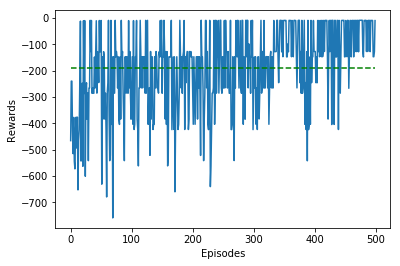

In [19]:
q_learning_pg_rewards, _ = zip(*[policy_gradient(env,500) for _ in range(10)])

avg_rewards = np.mean(q_learning_pg_rewards, axis=0)

mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

print('Mean Reward: {}'.format(mean_reward[0]))

In [20]:
actions,_=policy()
actions

(1, 2, 2, 0)

## Visualization

In [21]:
def play(actions):
    actions,_=policy()
    print [ACTIONS[actions[i]] for i in range(len(actions))]
    env = GridWorld()
    state = env.reset()
    done = False
    history = [state]
    for action in actions:    
        # Select action
        # Do the action
        next_state, reward, done = env.step(action)  
        history.append(next_state)
        # Update state and action        
        state = next_state  
        #raw_input("Press Enter to continue...")
        env.render(q_values= np.zeros((num_states, num_actions)),history=history, colorize_q=True)
        #raw_input("Press Enter to continue...")
        if done:
            return
    print 'path not found'

['DOWN', 'RIGHT', 'RIGHT', 'UP']


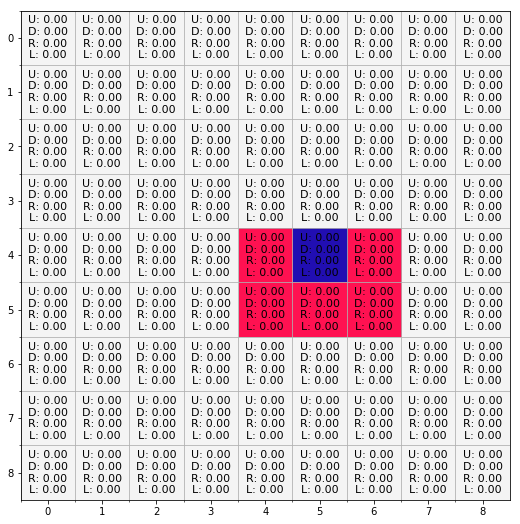

In [22]:
play(actions)